#### Purpose of the notebook
- To estimate baseline econometric models that quantify the association between preventive healthcare access and diabetes prevalence in Georgia and to examine whether these associations differ across socioeconomic groups.

#### Load the data for Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
# Load your prepared data
df = pd.read_csv("brfss_diabetes_cleaned.csv")

#### Outcome: Diabates prevalence

In [3]:
# Define the target survey question
diabetes_question = "Have you ever been told by a doctor that you have diabetes?"

# Filter rows that match the diabetes question
df_diab = df.query("Question == @diabetes_question").copy()

# Inspect the shape (rows, columns)
print("Shape of df_diab:", df_diab.shape)

Shape of df_diab: (1605, 11)


#### Preventive care: Routine checkup

In [4]:
# Define the target survey question
checkup_question = "About how long has it been since you last visited a doctor for a routine checkup?"

# Filter rows that match the checkup question
df_check = df.query("Question == @checkup_question").copy()

# Inspect the shape (rows, columns)
print("Shape of df_check:", df_check.shape)

Shape of df_check: (1941, 11)


#### Merge outcome and prevention by Year x SES group

In [6]:
# Define merge keys
merge_keys = ["Year", "Break_Out_Category", "Break_Out"]

# Merge diabetes outcome data with preventive checkup data
df_merged = pd.merge(
    df_diab,
    df_check,
    on=merge_keys,
    suffixes=("_diabetes", "_checkup")
)

# Inspect the shape (rows, columns)
print("Shape of merged DataFrame:", df_merged.shape)

# Optional: preview the first few rows
print(df_merged.head(2))


Shape of merged DataFrame: (9375, 19)
   Year Locationabbr_diabetes Locationdesc_diabetes Topic_diabetes  \
0  2024                    GA               Georgia       Diabetes   
1  2024                    GA               Georgia       Diabetes   

                                   Question_diabetes Break_Out_Category  \
0  Have you ever been told by a doctor that you h...            Overall   
1  Have you ever been told by a doctor that you h...            Overall   

  Break_Out Sample_Size_diabetes  Data_value_diabetes Question_Role_diabetes  \
0   Overall                1,242                 12.8     Outcome (Diabetes)   
1   Overall                1,242                 12.8     Outcome (Diabetes)   

  Variable_Name_diabetes Locationabbr_checkup Locationdesc_checkup  \
0        diabetes_status                   GA              Georgia   
1        diabetes_status                   GA              Georgia   

  Topic_checkup                                   Question_checkup  \
0  

#### Baseline Econometric Model

#### 1.Model specification
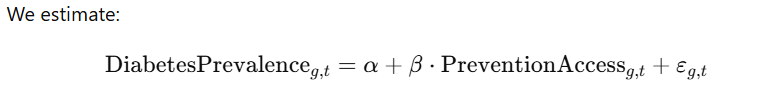

#### Scatter plot of the Diabates prevalence and preventive checkup Acess

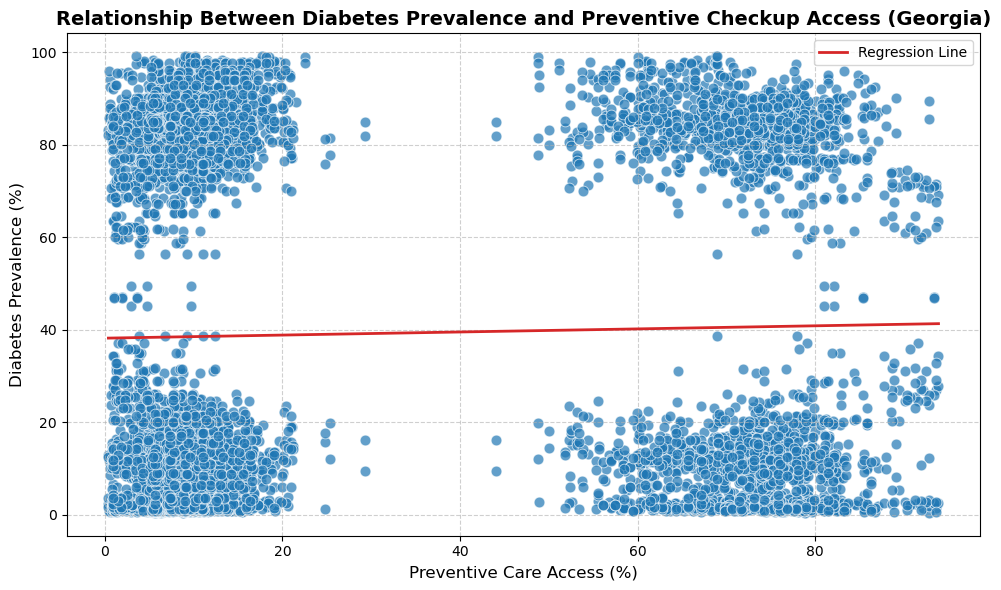

In [9]:
# Scatterplot of observed data
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_merged,
    x="Data_value_checkup",
    y="Data_value_diabetes",
    color="tab:blue",
    alpha=0.7,
    s=60
)

# Regression line from model1
x_vals = np.linspace(df_merged["Data_value_checkup"].min(),
                     df_merged["Data_value_checkup"].max(), 100)
y_vals = model1.params["Intercept"] + model1.params["Data_value_checkup"] * x_vals
plt.plot(x_vals, y_vals, color="tab:red", linewidth=2, label="Regression Line")

# Labels and title
plt.xlabel("Preventive Care Access (%)", fontsize=12)
plt.ylabel("Diabetes Prevalence (%)", fontsize=12)
plt.title("Relationship Between Diabetes Prevalence and Preventive Checkup Access (Georgia)",
          fontsize=14, weight="bold")

# Legend and grid
plt.legend()
plt.grid(axis="both", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

There is a weak linear relationship between preventive checkup access and diabetes prevalence. The data show substantial heterogeneity with very different diabetes levels observed at similar levels of preventive care access.

#### Estimation

In [7]:
import statsmodels.formula.api as smf

# Build an OLS regression model:
# Outcome: Diabetes prevalence
# Predictor: Preventive checkup access
model1 = smf.ols(
    formula="Data_value_diabetes ~ Data_value_checkup",
    data=df_merged
).fit(cov_type="HC3")   # HC3 = robust standard errors

# Display regression summary
print(model1.summary())

                             OLS Regression Results                            
Dep. Variable:     Data_value_diabetes   R-squared:                       0.001
Model:                             OLS   Adj. R-squared:                  0.001
Method:                  Least Squares   F-statistic:                     6.635
Date:                 Thu, 25 Dec 2025   Prob (F-statistic):             0.0100
Time:                         16:36:50   Log-Likelihood:                -47276.
No. Observations:                 9375   AIC:                         9.456e+04
Df Residuals:                     9373   BIC:                         9.457e+04
Df Model:                            1                                         
Covariance Type:                   HC3                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             38.1

##### Interpretation
Ordinary least squares estimation reveals a statistically significant but very small positive association between access to routine medical checkups and diabetes prevalence. The positive sign likely reflects selection and reverse causality as populations with higher diabetes burden are more likely to engage with the healthcare system

#### Controlling for Time Effects
- Add year fixed effects

In [10]:
# Build an OLS regression model:
# Outcome: Diabetes prevalence
# Predictors: Preventive checkup access + Year fixed effects
model2 = smf.ols(
    formula="Data_value_diabetes ~ Data_value_checkup + C(Year)",
    data=df_merged
).fit(cov_type="HC3")   # HC3 = heteroskedasticity-robust standard errors

# Display regression summary
print(model2.summary())


                             OLS Regression Results                            
Dep. Variable:     Data_value_diabetes   R-squared:                       0.006
Model:                             OLS   Adj. R-squared:                  0.005
Method:                  Least Squares   F-statistic:                     4.844
Date:                 Thu, 25 Dec 2025   Prob (F-statistic):           5.27e-08
Time:                         17:09:52   Log-Likelihood:                -47250.
No. Observations:                 9375   AIC:                         9.453e+04
Df Residuals:                     9362   BIC:                         9.462e+04
Df Model:                           12                                         
Covariance Type:                   HC3                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             35.1

##### Interpretation 
After accounting for year-to-year differences, preventive checkup access is still only weakly associated with diabetes prevalence and most variation in diabetes prevalence is explained by time trends rather than prevention access itself.

###### The model is not designed for prediction but for diagnosing associations and motivating causal analysis.

#### Heterogeneity by Socioeconomic Status
 - Interaction with income groups

In [12]:
# Filter merged dataset for Income category
df_income = df_merged.query("Break_Out_Category == 'Household Income'").copy()

# Build an OLS regression model:
# Outcome: Diabetes prevalence
# Predictors: Preventive checkup access, income group interactions, and year fixed effects
model3 = smf.ols(
    formula="Data_value_diabetes ~ Data_value_checkup * C(Break_Out) + C(Year)",
    data=df_income
).fit(cov_type="HC3")   # HC3 = heteroskedasticity-robust standard errors

# Display regression summary
print(model3.summary())


                             OLS Regression Results                            
Dep. Variable:     Data_value_diabetes   R-squared:                       0.036
Model:                             OLS   Adj. R-squared:                  0.022
Method:                  Least Squares   F-statistic:                     2.602
Date:                 Thu, 25 Dec 2025   Prob (F-statistic):           1.87e-05
Time:                         17:19:24   Log-Likelihood:                -9476.7
No. Observations:                 1902   AIC:                         1.901e+04
Df Residuals:                     1875   BIC:                         1.916e+04
Df Model:                           26                                         
Covariance Type:                   HC3                                         
                                                           coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------

##### Interpretation.
Allowing the association between preventive healthcare access and diabetes prevalence to vary across income groups yields no statistically significant interaction effects. This suggests that simple linear interaction models are insufficient to capture heterogeneity in the relationship between prevention and chronic disease burden. The absence of significant interactions likely reflects selection into preventive care, aggregation at the subgroup level and nonlinear responses to prevention. These findings motivate the use of causal inference and machine learning methods to better identify heterogeneous effects and high-risk populations.

#### Relationship between preventive checkup access and diabetes prevalence differs across income groups

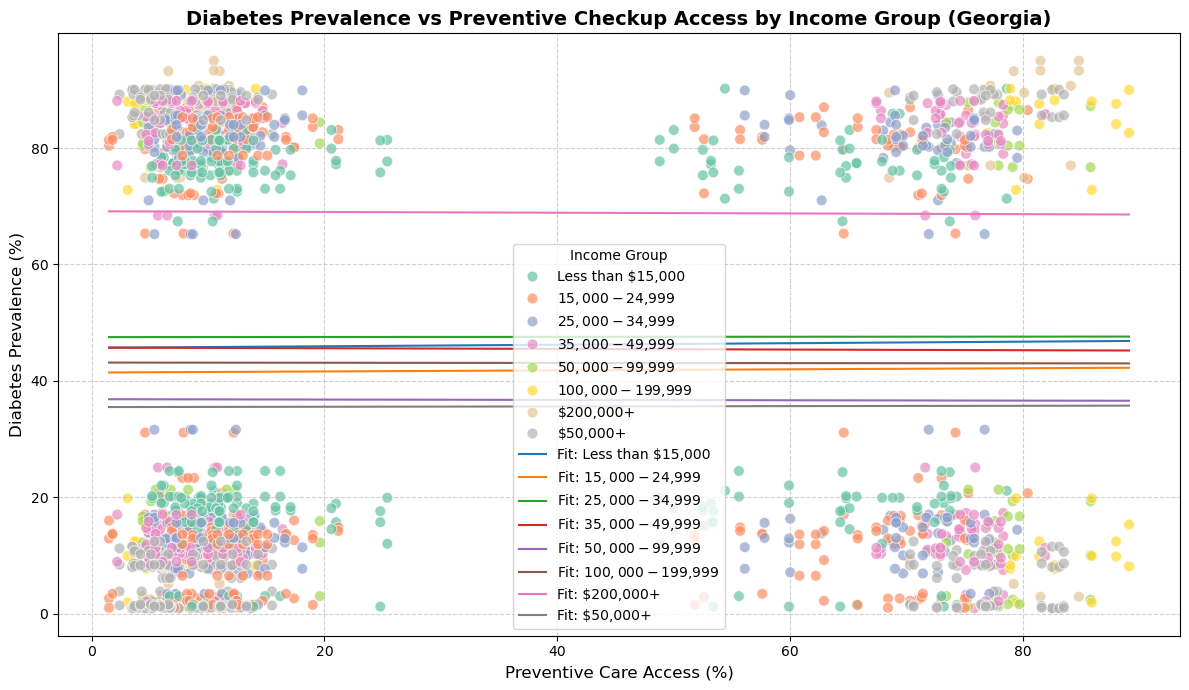

In [13]:
# Scatterplot of observed data by income group
plt.figure(figsize=(12, 7))
sns.scatterplot(
    data=df_income,
    x="Data_value_checkup",
    y="Data_value_diabetes",
    hue="Break_Out",
    palette="Set2",
    alpha=0.7,
    s=60
)

# Regression lines for each income group
x_vals = np.linspace(df_income["Data_value_checkup"].min(),
                     df_income["Data_value_checkup"].max(), 100)

for group in df_income["Break_Out"].unique():
    # Build a dataframe for prediction
    pred_df = pd.DataFrame({
        "Data_value_checkup": x_vals,
        "Break_Out": group,
        "Year": df_income["Year"].mode()[0]  # pick a reference year
    })
    y_pred = model3.predict(pred_df)
    plt.plot(x_vals, y_pred, label=f"Fit: {group}")

# Labels and title
plt.xlabel("Preventive Care Access (%)", fontsize=12)
plt.ylabel("Diabetes Prevalence (%)", fontsize=12)
plt.title("Diabetes Prevalence vs Preventive Checkup Access by Income Group (Georgia)",
          fontsize=14, weight="bold")

# Legend and grid
plt.legend(title="Income Group")
plt.grid(axis="both", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

#### Robustness: Education Stratification

In [14]:
# Filter merged dataset for Education category
df_edu = df_merged.query("Break_Out_Category == 'Education Attained'").copy()

# Build an OLS regression model:
# Outcome: Diabetes prevalence
# Predictors: Preventive checkup access, education group interactions, and year fixed effects
model4 = smf.ols(
    formula="Data_value_diabetes ~ Data_value_checkup * C(Break_Out) + C(Year)",
    data=df_edu
).fit(cov_type="HC3")   # HC3 = heteroskedasticity-robust standard errors

# Display regression summary
print(model4.summary())


                             OLS Regression Results                            
Dep. Variable:     Data_value_diabetes   R-squared:                       0.017
Model:                             OLS   Adj. R-squared:                  0.008
Method:                  Least Squares   F-statistic:                     2.113
Date:                 Thu, 25 Dec 2025   Prob (F-statistic):            0.00410
Time:                         17:30:53   Log-Likelihood:                -9941.5
No. Observations:                 1984   AIC:                         1.992e+04
Df Residuals:                     1965   BIC:                         2.003e+04
Df Model:                           18                                         
Covariance Type:                   HC3                                         
                                                        coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------

#### visualize the interaction effects for education groups

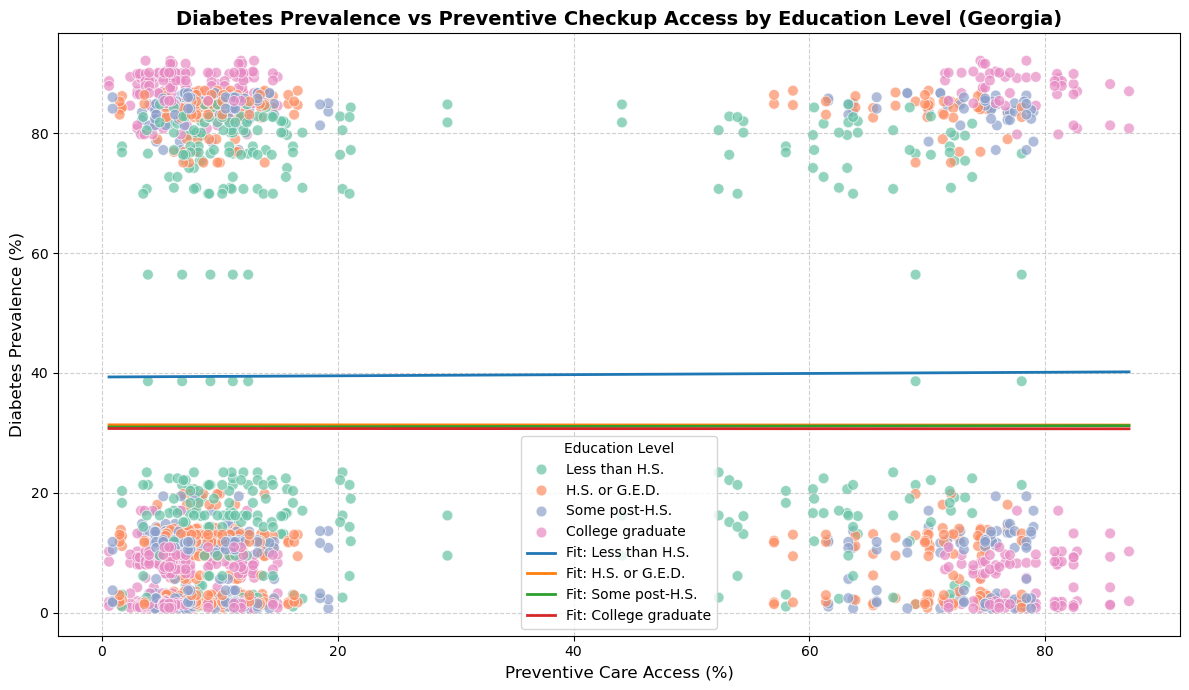

In [15]:
# Scatterplot of observed data by education group
plt.figure(figsize=(12, 7))
sns.scatterplot(
    data=df_edu,
    x="Data_value_checkup",
    y="Data_value_diabetes",
    hue="Break_Out",
    palette="Set2",
    alpha=0.7,
    s=60
)

# Regression lines for each education group
x_vals = np.linspace(df_edu["Data_value_checkup"].min(),
                     df_edu["Data_value_checkup"].max(), 100)

for group in df_edu["Break_Out"].unique():
    # Build a dataframe for prediction
    pred_df = pd.DataFrame({
        "Data_value_checkup": x_vals,
        "Break_Out": group,
        "Year": df_edu["Year"].mode()[0]  # pick a reference year
    })
    y_pred = model4.predict(pred_df)
    plt.plot(x_vals, y_pred, linewidth=2, label=f"Fit: {group}")

# Labels and title
plt.xlabel("Preventive Care Access (%)", fontsize=12)
plt.ylabel("Diabetes Prevalence (%)", fontsize=12)
plt.title("Diabetes Prevalence vs Preventive Checkup Access by Education Level (Georgia)",
          fontsize=14, weight="bold")

# Legend and grid
plt.legend(title="Education Level")
plt.grid(axis="both", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

##### Interpretation.
Stratifying the relationship between preventive healthcare access and diabetes prevalence by education level reveals no strong linear association within education groups. Fitted lines are nearly flat and similar across education categories indicating that simple linear moderation by education does not capture heterogeneity in the prevention–diabetes relationship. Education appears to influence baseline diabetes prevalence rather than the marginal association with preventive care access.

#### Summary

This section shows that simple linear and interaction models are insufficient to capture the complex heterogeneous relationship between preventive healthcare access and diabetes prevalence thereby motivating the use of causal inference and machine learning methods to identify effective and equitable prevention strategies.